In [88]:
import os
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import shap
from utils.plot_map import plot_feature_on_map
import joblib

In [104]:
data_path = "../../../../../../../Volumes/T7 Shield/preprocessed_new_exp1_full"
# data_path = "../../data/preprocessed_new"

timestamp = datetime.now().strftime('%Y-%m-%d_%H-%M')
# for results,model and scaler
folder_path = "../plots/perceptron/flux/" + timestamp
os.makedirs(folder_path, exist_ok=True)

In [ ]:
feature_files = [os.path.join(data_path, f"{i}_features.npy") for i in range(1, 733)]
target_files = [os.path.join(data_path, f"{i}_targets.npy") for i in range(1, 733)]
features_list = []
targets_list = []

for f_file, t_file in zip(feature_files, target_files):
    features = np.load(f_file) 
    targets = np.load(t_file)  
    features_flat = features.reshape(-1, features.shape[2])  
    targets_flat = targets.reshape(-1, targets.shape[2])   
    features_list.append(features_flat)
    targets_list.append(targets_flat)

features_array = np.concatenate(features_list, axis=0)  
all_targets_array = np.concatenate(targets_list, axis=0)   

targets_array = all_targets_array[..., 2]

mask = features_array[:, 11] == 1

print("Number of samples before filtering:", features_array.shape[0])
# Apply the mask to both arrays
filtered_features = features_array[mask]
filtered_targets = targets_array[mask]
print("Number of samples after filtering:", filtered_features.shape[0])

filtered_features = np.delete(filtered_features,11, axis=-1)



Number of samples before filtering: 44007840
Number of samples after filtering: 31138548


In [ ]:
X_train = filtered_features[:int(0.8 * len(filtered_features))]
Y_train = filtered_targets[:int(0.8 * len(filtered_targets))]
X_val = filtered_features[int(0.8 * len(filtered_features)):int(0.9 * len(filtered_features))]
Y_val = filtered_targets[int(0.8 * len(filtered_targets)):int(0.9 * len(filtered_targets))]
X_test = filtered_features[int(0.9 * len(filtered_features)):]
Y_test = filtered_targets[int(0.9 * len(filtered_targets)):]

feature_scaler = StandardScaler()

X_train = feature_scaler.fit_transform(X_train)
X_val = feature_scaler.transform(X_val)
X_test = feature_scaler.transform(X_test)

joblib.dump(feature_scaler, folder_path + '/scaler.pkl')
# target_scaler = StandardScaler()
# Y_train = target_scaler.fit_transform(Y_train.reshape(-1, 1)).flatten()
# Y_val = target_scaler.transform(Y_val.reshape(-1, 1)).flatten()
# Y_test = target_scaler.transform(Y_test.reshape(-1, 1)).flatten()

# Create a random permutation of indices
# perm = np.random.permutation(X_train.shape[0])
# X_train = X_train[perm]
# Y_train = Y_train[perm]

# perm_val = np.random.permutation(X_val.shape[0])
# X_val = X_val[perm_val]
# Y_val = Y_val[perm_val]


['../plots/perceptron/flux/2025-05-30_14-27/scaler.pkl']

In [108]:
# Compute statistics
mean = np.mean(Y_train)
std = np.std(Y_train)
min_val = np.min(Y_train)
max_val = np.max(Y_train)

print(f"Training data: Mean: {mean:.4f}, Std: {std:.4f}, Min: {min_val:.4f}, Max: {max_val:.4f}")

mean = np.mean(Y_val)
std = np.std(Y_val)
min_val = np.min(Y_val)
max_val = np.max(Y_val)
print(f"Validation data: Mean: {mean:.4f}, Std: {std:.4f}, Min: {min_val:.4f}, Max: {max_val:.4f}")

mean = np.mean(Y_test)
std = np.std(Y_test)
min_val = np.min(Y_test)
max_val = np.max(Y_test)
print(f"Test data: Mean: {mean:.4f}, Std: {std:.4f}, Min: {min_val:.4f}, Max: {max_val:.4f}")

Training data: Mean: 0.4965, Std: 1.4904, Min: -49.9030, Max: 22.9568
Validation data: Mean: 0.6710, Std: 1.6410, Min: -40.2793, Max: 27.1420
Test data: Mean: 0.7048, Std: 1.6631, Min: -47.6922, Max: 22.1484


In [109]:
n_epochs = 10
batch_size = 4096
lr = 0.0002

model = tf.keras.models.Sequential([
     tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
     tf.keras.layers.BatchNormalization(),
    
     tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
     tf.keras.layers.BatchNormalization(),
     tf.keras.layers.Dropout(0.2),
    
     tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
     tf.keras.layers.BatchNormalization(),
     tf.keras.layers.Dropout(0.2),

     tf.keras.layers.Dense(1, activation='linear')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
    loss=tf.keras.losses.Huber(delta=2.0),
    metrics=['mae']
)

In [110]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6)
 
history = model.fit(
    X_train,
    Y_train,
    epochs=n_epochs,             
    batch_size=batch_size,          
    validation_data=(X_val, Y_val),
    callbacks=[early_stopping, lr_scheduler])

Epoch 1/10
6082/6082 ━━━━━━━━━━━━━━━━━━━━ 98s 16ms/step - loss: 0.6246 - mae: 0.6256 - val_loss: 0.2965 - val_mae: 0.4771 - learning_rate: 2.0000e-04
Epoch 2/10
6082/6082 ━━━━━━━━━━━━━━━━━━━━ 98s 16ms/step - loss: 0.2325 - mae: 0.4217 - val_loss: 0.2657 - val_mae: 0.4615 - learning_rate: 2.0000e-04
Epoch 3/10
6082/6082 ━━━━━━━━━━━━━━━━━━━━ 98s 16ms/step - loss: 0.2096 - mae: 0.4057 - val_loss: 0.2528 - val_mae: 0.4534 - learning_rate: 2.0000e-04
Epoch 4/10
6082/6082 ━━━━━━━━━━━━━━━━━━━━ 97s 16ms/step - loss: 0.2010 - mae: 0.3988 - val_loss: 0.2453 - val_mae: 0.4474 - learning_rate: 2.0000e-04
Epoch 5/10
6082/6082 ━━━━━━━━━━━━━━━━━━━━ 98s 16ms/step - loss: 0.1963 - mae: 0.3948 - val_loss: 0.2455 - val_mae: 0.4495 - learning_rate: 2.0000e-04
Epoch 6/10
6082/6082 ━━━━━━━━━━━━━━━━━━━━ 99s 16ms/step - loss: 0.1930 - mae: 0.3918 - val_loss: 0.2470 - val_mae: 0.4526 - learning_rate: 2.0000e-04
Epoch 7/10
6082/6082 ━━━━━━━━━━━━━━━━━━━━ 97s 16ms/step - loss: 0.1848 - mae: 0.3832 - val_loss: 0.2

In [111]:
model.save(folder_path + "/model.keras")

In [112]:
model = tf.keras.models.load_model(folder_path + "/model.keras")
# run model on test data
test_pred = model.predict(X_test)
# test_pred = target_scaler.inverse_transform(test_pred)

mse = mean_squared_error(test_pred, Y_test)
mae = mean_absolute_error(test_pred, Y_test)
print(f"Mean Squared Error: {mse:.2f}")
print(f"Mean Absolute Error: {mae:.2f}")

97308/97308 ━━━━━━━━━━━━━━━━━━━━ 32s 332us/step
Mean Squared Error: 0.52
Mean Absolute Error: 0.46


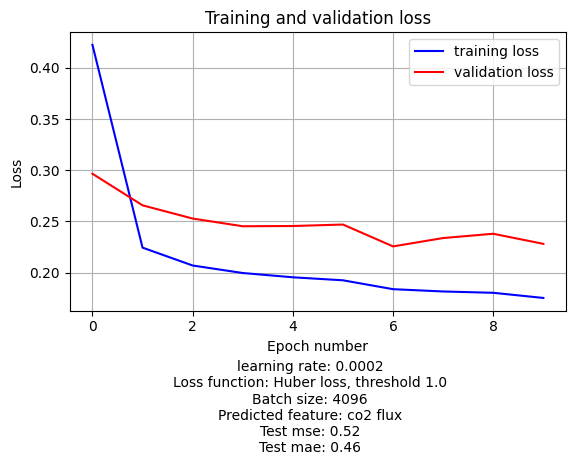

In [113]:
plt.plot(history.history['loss'], color = 'blue', label = 'training loss')
plt.plot(history.history['val_loss'], color = 'red', label = 'validation loss')
plt.xlabel('Epoch number')
plt.ylabel('Loss')
plt.title('Training and validation loss')
plt.grid(True)
plt.legend()

plt.subplots_adjust(bottom=0.3)
plt.figtext(0.5, 0.01, f"learning rate: {lr}\nLoss function: Huber loss, threshold 1.0\nBatch size: {str(batch_size)}\nPredicted feature: co2 flux\nTest mse: {mse:.2f}\nTest mae: {mae:.2f}",
            wrap=True, horizontalalignment='center', fontsize=10, color='black')

path = folder_path + '/' + timestamp + '_training_validation_loss.png'
plt.savefig(path, format='png', dpi=300)
plt.show()  

In [114]:
# compute SHAP values
# explainer = shap.Explainer(model, X_t[:1000])
# explainer = shap.explainers.Permutation(model, X_t)
# shap_values = explainer(X[:100])
# shap_values = explainer(X_t[:100])

# shap.plots.waterfall(shap_values[0], max_display=20)



In [115]:
# shap.plots.waterfall(shap_values[0], max_display=20)

In [116]:
# shap.plots.scatter(shap_values[:, :])

In [ ]:
feature_files = [os.path.join(data_path, f"{i}_features.npy") for i in range(720, 733)]
target_files = [os.path.join(data_path, f"{i}_targets.npy") for i in range(720, 733)]

X = np.stack([np.load(fp) for fp in feature_files])
Y = np.stack([np.load(fp) for fp in target_files])

Y = Y[..., 2]

mask = X[0,:,:,11] == 1

n_samples, h, w, n_features = X.shape
X_flat = X.reshape(-1,n_features)
X_flat = np.delete(X_flat, 11, axis=1)

# folder_path = "../plots/perceptron/flux/2025-05-28_10-09"
# model = tf.keras.models.load_model(folder_path + "/model.keras")

# feature_scaler= joblib.load(folder_path + "/scaler.pkl")
X_scaled_flat = feature_scaler.transform(X_flat)
reconstruction_flat = model.predict(X_scaled_flat)
reconstruction = reconstruction_flat.reshape(n_samples, h, w)
diff = abs(reconstruction-Y)

averaged_reconstruction = np.mean(reconstruction, axis=0) * mask
averaged_truth = np.mean(Y, axis=0) * mask
averaged_diff = np.mean(diff, axis=0) * mask
plot_feature_on_map(averaged_diff,-77,90,0,2,folder_path, 'averaged_reconstruction_error','CO2 Flux - Absolute reconstruction error averaged over all 12 month of 2018')
plot_feature_on_map(averaged_truth,-77,90,-5,5,folder_path, 'averaged_target','CO2 Flux - Target averaged over all 12 month of 2018')
plot_feature_on_map(averaged_reconstruction,-77,90,-5,5,folder_path, 'averaged_reconstruction','CO2 Flux - Reconstruction averaged over all 12 month of 2018')



ValueError: X has 15 features, but StandardScaler is expecting 10 features as input.